<a href="https://colab.research.google.com/github/vintagedeek/mnist/blob/master/kaggle_mnist_cnn_v1_99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
import pandas as pd
import numpy as np

from collections import OrderedDict, namedtuple
from itertools import product
import time
from IPython.display import display, clear_output
import json

import torch 
from torchvision.transforms import Normalize
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F

from scipy.ndimage.interpolation import shift
from PIL import Image

import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-whitegrid')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train_url = "https://raw.githubusercontent.com/wehrley/Kaggle-Digit-Recognizer/master/train.csv"
df_train = pd.read_csv(train_url)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [3]:
test_url = 'https://raw.githubusercontent.com/wehrley/Kaggle-Digit-Recognizer/master/test.csv'
df_test = pd.read_csv(test_url)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


# Data Normalization

In [4]:
df_train_copy = df_train.copy()
df_train_copy = torch.tensor(np.array(df_train_copy), dtype=torch.float32)
pixels_only = torch.narrow(df_train_copy, 1, 1, 784) # start at 1 to 1 +  = 42000 total samples
df_train_copy_mean = pixels_only.sum()/(42000*28*28)
df_train_copy_var = (1 / (42000 * 28 * 28)) * ((pixels_only - df_train_copy_mean)**2).sum()
df_train_copy_std = df_train_copy_var.sqrt()

train_set = df_train_copy[0:29400]
train = torch.narrow(train_set, 1, 1, 784)
train = (train - df_train_copy_mean) / df_train_copy_std
train_labels = torch.narrow(train_set, 1, 0, 1)
train_labels = torch.tensor(train_labels, dtype=torch.int64).squeeze() # they are 2D if you don't squeeze

val_set = df_train_copy[29400:]
val = torch.narrow(val_set, 1, 1, 784)
val = (val - df_train_copy_mean) / df_train_copy_std
val_labels = torch.narrow(val_set, 1, 0, 1)
val_labels = torch.tensor(val_labels, dtype=torch.int64).squeeze() # they are 2D if you don't squeeze

df_test_copy = df_test.copy()
df_test_copy = torch.tensor(np.array(df_test_copy), dtype=torch.float32)
df_test_mean = df_test_copy.sum()/(28000 * 28 * 28)
df_test_var = (1 / (28000 * 28 * 28)) * ((df_test_copy - df_test_mean)**2).sum()
df_test_std = df_test_var.sqrt()
test = (df_test_copy - df_test_mean) / (df_test_std)


print(df_train_copy_mean, df_train_copy_std, train.mean(), train.std(), val.mean(), val.std())
print(df_test_mean, df_test_std, test.mean(), test.std())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(33.4023) tensor(78.4047) tensor(-7.0261e-05) tensor(1.0030) tensor(0.0010) tensor(1.0046)
tensor(33.3481) tensor(78.4204) tensor(-0.0002) tensor(1.0025)


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
val.shape

torch.Size([12600, 784])

In [7]:
train = train.reshape(29400, 1, 28, 28)
val = val.reshape(12600, 1, 28, 28)
test = test.reshape(28000, 1, 28, 28)
print(train.shape, val.shape, test.shape)

torch.Size([29400, 1, 28, 28]) torch.Size([12600, 1, 28, 28]) torch.Size([28000, 1, 28, 28])


In [26]:
validation_set = val.to(device)
validation_labels = val_labels.to(device) 

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

class RunManager():
    def __init__(self):
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.val_correct = 0
        self.epoch_start_time = None
        
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        
        self.network = None

       
    def begin_run(self, run, network):
        self.run_start_time = time.time()
        
        self.epoch_count = 0
        self.run_params = run
        self.run_count += 1
        
        self.network = network
        
    def end_run(self):
        self.epoch_count = 0
    
    def begin_epoch(self):
        self.epoch_start_time = time.time()
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.val_correct = 0
    
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        loss = self.epoch_loss / len(train)
        train_accuracy = self.epoch_num_correct / len(train)

        val_accuracy = self.val_correct/len(validation_set)

            
        results = OrderedDict()
        results["run"] = self.run_count
        results['epoch'] = self.epoch_count
        results['loss'] = loss
        results['train_accuracy'] = train_accuracy
        results['val_accuracy'] = val_accuracy
        results['epoch duration'] = epoch_duration
        results['run duration'] = run_duration
        for k, v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient='columns')
        clear_output(wait=True)
        display(df)
    
    def track_loss(self, loss):
        self.epoch_loss += loss.item() * 10
    
    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)
      
    def track_val_accuracy(self, model):
        with torch.no_grad():
            validation_preds = model(validation_set)
            self.val_correct += validation_preds.argmax(dim=1).eq(validation_labels).sum().item()
   
    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    def save(self, fileName): # save in json and csv
        
        pd.DataFrame.from_dict(self.run_data, orient='columns').to_csv(f'{fileName}.csv')
        
        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)


params = OrderedDict(
    lr = [0.01],
    batch_size = [20],
    device = ['cuda'],
    weight_decay = [0.0])

m = RunManager()
for run in RunBuilder.get_runs(params):

    network = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
        nn.BatchNorm2d(6),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Flatten(start_dim=1),
        nn.Linear(in_features=6 * 12 * 12, out_features=10),
        nn.Sigmoid()).to(device)
    
    mini_batches = [train[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    mini_labels = [train_labels[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    optimizer = optim.Adam(network.parameters(), lr=run.lr, weight_decay=run.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    m.begin_run(run, network)
    for epoch in range(25):
        m.begin_epoch()
        for b in range(0, len(mini_batches)):
            images = mini_batches[b].to(device)
            labels = mini_labels[b].to(device)
            preds = network(images) # pass batch
            loss = F.cross_entropy(preds, labels) # calculate loss
            optimizer.zero_grad() # zero gradients
            loss.backward() # calculate gradients
            optimizer.step() # update weights

            m.track_loss(loss)
            m.track_num_correct(preds, labels)
        m.track_val_accuracy(network)
        m.end_epoch()
        scheduler.step()
    m.end_run()

pd.DataFrame.from_dict(m.run_data).sort_values('val_accuracy', ascending=False)[0:15]

,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
0,1,1,0.811674,0.836633,0.958413,2.880777,2.880780,0.01,20,cuda,0.0
1,1,2,0.749572,0.966973,0.974048,2.820071,5.724782,0.01,20,cuda,0.0
2,1,3,0.746136,0.974150,0.970556,2.778045,8.526617,0.01,20,cuda,0.0
3,1,4,0.744352,0.975476,0.975952,2.790708,11.340928,0.01,20,cuda,0.0
4,1,5,0.743827,0.976667,0.972857,2.754700,14.120637,0.01,20,cuda,0.0
5,1,6,0.741985,0.979626,0.974048,2.812637,16.957066,0.01,20,cuda,0.0
6,1,7,0.741817,0.979592,0.978016,2.765887,19.745248,0.01,20,cuda,0.0
7,1,8,0.741206,0.980782,0.977302,2.807077,22.576421,0.01,20,cuda,0.0
8,1,9,0.741409,0.980374,0.976587,2.794776,25.395977,0.01,20,cuda,0.0
9,1,10,0.740507,0.981905,0.976587,2.789986,28.210655,0.01,20,cuda,0.0


,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
19,1,20,0.735411,0.987687,0.982302,2.787405,56.375055,0.01,20,cuda,0.0
20,1,21,0.735269,0.988095,0.982063,2.764401,59.165885,0.01,20,cuda,0.0
24,1,25,0.735151,0.987925,0.981984,2.769091,70.395626,0.01,20,cuda,0.0
23,1,24,0.735169,0.987925,0.981984,2.786614,67.598051,0.01,20,cuda,0.0
22,1,23,0.735190,0.988061,0.981905,2.782071,64.782331,0.01,20,cuda,0.0
21,1,22,0.735218,0.988129,0.981905,2.778339,61.972239,0.01,20,cuda,0.0
18,1,19,0.735521,0.987551,0.981587,2.769684,53.560291,0.01,20,cuda,0.0
17,1,18,0.735630,0.987755,0.981508,2.787733,50.763219,0.01,20,cuda,0.0
16,1,17,0.735787,0.987381,0.981270,2.822498,47.946937,0.01,20,cuda,0.0
14,1,15,0.736132,0.987075,0.981111,2.815995,42.276937,0.01,20,cuda,0.0


### Notes
- Adding regularization seems to harm performance.
- Batch size initially optimized at 1,000 with 97% acc (beat lower batch sizes). After optimizing LR at 0.01 (from 0.1), lowered batch to 20 and improved val accuracy from 97.8% to 98.3%

# 98.3% 
    params = OrderedDict(
    lr = [0.01],
    batch_size = [20],
    device = ['cuda'],
    weight_decay = [0.0])
    epochs=25
    m = RunManager()
    for run in RunBuilder.get_runs(params):

    network = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
    nn.BatchNorm2d(6),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.ReLU(),
    nn.Flatten(start_dim=1),
    nn.Linear(in_features=6 * 12 * 12, out_features=10),
    nn.Sigmoid()).to(device)

In [27]:
m.save('kaggle_mnist_cnn_v1_best_run') 
# to download, click folder (3rd icon down) on left pane

In [8]:

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

class RunManager():
    def __init__(self):
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.val_correct = 0
        self.epoch_start_time = None
        
        self.run_params = None
        self.run_count = 0
        self.run_data = []
        self.run_start_time = None
        
        self.network = None

       
    def begin_run(self, run, network):
        self.run_start_time = time.time()
        
        self.epoch_count = 0
        self.run_params = run
        self.run_count += 1
        
        self.network = network
        
    def end_run(self):
        self.epoch_count = 0
    
    def begin_epoch(self):
        self.epoch_start_time = time.time()
        self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_num_correct = 0
        self.val_correct = 0
    
    def end_epoch(self):
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        loss = self.epoch_loss / len(train)
        train_accuracy = self.epoch_num_correct / len(train)

        val_accuracy = self.val_correct/len(validation_set)

            
        results = OrderedDict()
        results["run"] = self.run_count
        results['epoch'] = self.epoch_count
        results['loss'] = loss
        results['train_accuracy'] = train_accuracy
        results['val_accuracy'] = val_accuracy
        results['epoch duration'] = epoch_duration
        results['run duration'] = run_duration
        for k, v in self.run_params._asdict().items(): results[k] = v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient='columns')
        clear_output(wait=True)
        display(df)
    
    def track_loss(self, loss):
        self.epoch_loss += loss.item() * 10
    
    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)
      
    def track_val_accuracy(self, model):
        with torch.no_grad():
            validation_preds = model(validation_set)
            self.val_correct += validation_preds.argmax(dim=1).eq(validation_labels).sum().item()
   
    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    def save(self, fileName): # save in json and csv
        
        pd.DataFrame.from_dict(self.run_data, orient='columns').to_csv(f'{fileName}.csv')
        
        with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
            json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [13]:
validation_set = val.to(device)
validation_labels = val_labels.to(device) 

params = OrderedDict(
    lr = [0.1, 0.01, 0.001],
    batch_size = [20, 50, 1000],
    device = ['cuda'],
    weight_decay = [0.0])

m = RunManager()
for run in RunBuilder.get_runs(params):

    network = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
        nn.BatchNorm2d(6),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5, stride=1),
        nn.BatchNorm2d(12),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Flatten(start_dim=1),
        nn.Linear(in_features=12 * 4 * 4, out_features=10),
        nn.Sigmoid()).to(device)
    
    mini_batches = [train[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    mini_labels = [train_labels[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    optimizer = optim.Adam(network.parameters(), lr=run.lr, weight_decay=run.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    m.begin_run(run, network)
    for epoch in range(25):
        m.begin_epoch()
        for b in range(0, len(mini_batches)):
            images = mini_batches[b].to(device)
            labels = mini_labels[b].to(device)
            preds = network(images) # pass batch
            loss = F.cross_entropy(preds, labels) # calculate loss
            optimizer.zero_grad() # zero gradients
            loss.backward() # calculate gradients
            optimizer.step() # update weights

            m.track_loss(loss)
            m.track_num_correct(preds, labels)
        m.track_val_accuracy(network)
        m.end_epoch()
        scheduler.step()
    m.end_run()

pd.DataFrame.from_dict(m.run_data).sort_values('val_accuracy', ascending=False)[0:15]

,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
0,1,1,1.067568,0.257959,0.425952,3.959822,3.959829,0.100,20,cuda,0.0
1,1,2,1.004507,0.488605,0.532381,3.896024,7.877662,0.100,20,cuda,0.0
2,1,3,0.994159,0.511156,0.530079,4.017843,11.924020,0.100,20,cuda,0.0
3,1,4,0.997214,0.489252,0.497698,3.911936,15.859976,0.100,20,cuda,0.0
4,1,5,0.992459,0.507245,0.501349,3.951434,19.838424,0.100,20,cuda,0.0
...,...,...,...,...,...,...,...,...,...,...,...
220,9,21,0.015495,0.967687,0.966667,0.212385,5.211653,0.001,1000,cuda,0.0
221,9,22,0.015494,0.967721,0.966746,0.215158,5.458999,0.001,1000,cuda,0.0
222,9,23,0.015494,0.967789,0.966825,0.217883,5.710900,0.001,1000,cuda,0.0
223,9,24,0.015493,0.967789,0.966825,0.214801,5.962245,0.001,1000,cuda,0.0


,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
122,5,23,0.293366,0.992041,0.987778,1.603971,38.200755,0.01,50,cuda,0.0
121,5,22,0.293373,0.991973,0.987778,1.627964,36.564212,0.01,50,cuda,0.0
123,5,24,0.293360,0.992109,0.987698,1.599381,39.833214,0.01,50,cuda,0.0
124,5,25,0.293354,0.992109,0.987698,1.645673,41.511871,0.01,50,cuda,0.0
120,5,21,0.293393,0.991871,0.987619,1.611629,34.903389,0.01,50,cuda,0.0
113,5,14,0.293717,0.990884,0.987302,1.623376,23.299186,0.01,50,cuda,0.0
119,5,20,0.293413,0.991565,0.987222,1.623946,33.258661,0.01,50,cuda,0.0
114,5,15,0.293643,0.990918,0.987143,1.636322,24.970481,0.01,50,cuda,0.0
115,5,16,0.293580,0.991224,0.987143,1.647505,26.650425,0.01,50,cuda,0.0
117,5,18,0.293484,0.991463,0.987143,1.608696,29.935022,0.01,50,cuda,0.0


In [14]:
m.save('kaggle_mnist_cnn_v1_2_hidden_no_reg')

In [22]:
validation_set = val.to(device)
validation_labels = val_labels.to(device) 

params = OrderedDict(
    lr = [0.01],
    batch_size = [100],
    device = ['cuda'],
    weight_decay = [0.0])

m = RunManager()
for run in RunBuilder.get_runs(params):

    network = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
        nn.BatchNorm2d(6),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5, stride=1),
        nn.BatchNorm2d(12),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Flatten(start_dim=1),
        nn.Linear(in_features=12 * 4 * 4, out_features=30),
        nn.BatchNorm1d(30),
        nn.ReLU(),
        nn.Linear(in_features=30, out_features=10),
        nn.Sigmoid()).to(device)
    
    mini_batches = [train[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    mini_labels = [train_labels[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    optimizer = optim.Adam(network.parameters(), lr=run.lr, weight_decay=run.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    m.begin_run(run, network)
    for epoch in range(20):
        m.begin_epoch()
        for b in range(0, len(mini_batches)):
            images = mini_batches[b].to(device)
            labels = mini_labels[b].to(device)
            preds = network(images) # pass batch
            loss = F.cross_entropy(preds, labels) # calculate loss
            optimizer.zero_grad() # zero gradients
            loss.backward() # calculate gradients
            optimizer.step() # update weights

            m.track_loss(loss)
            m.track_num_correct(preds, labels)
        m.track_val_accuracy(network)
        m.end_epoch()
        scheduler.step()
    m.end_run()

pd.DataFrame.from_dict(m.run_data).sort_values('val_accuracy', ascending=False)[0:15]

,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
0,1,1,0.154711,0.947653,0.978095,1.074635,1.074641,0.01,100,cuda,0.0
1,1,2,0.148137,0.980612,0.985000,1.053897,2.153223,0.01,100,cuda,0.0
2,1,3,0.147622,0.985612,0.984762,1.071585,3.247382,0.01,100,cuda,0.0
3,1,4,0.147376,0.987075,0.985079,1.055163,4.325586,0.01,100,cuda,0.0
4,1,5,0.147152,0.988980,0.985476,1.081292,5.428823,0.01,100,cuda,0.0
5,1,6,0.146842,0.992653,0.989365,1.077050,6.529460,0.01,100,cuda,0.0
6,1,7,0.146667,0.994150,0.989683,1.059361,7.613167,0.01,100,cuda,0.0
7,1,8,0.146601,0.994966,0.989444,1.072293,8.711233,0.01,100,cuda,0.0
8,1,9,0.146557,0.995272,0.989762,1.065731,9.801857,0.01,100,cuda,0.0
9,1,10,0.146522,0.995578,0.989683,1.053963,10.880945,0.01,100,cuda,0.0


,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
19,1,20,0.146454,0.996190,0.990159,1.076996,21.855674,0.01,100,cuda,0.0
18,1,19,0.146455,0.996190,0.990159,1.082892,20.751065,0.01,100,cuda,0.0
17,1,18,0.146456,0.996190,0.990159,1.076753,19.639535,0.01,100,cuda,0.0
16,1,17,0.146456,0.996156,0.990159,1.089730,18.535431,0.01,100,cuda,0.0
15,1,16,0.146456,0.996156,0.990159,1.089491,17.415943,0.01,100,cuda,0.0
14,1,15,0.146463,0.996122,0.990159,1.070127,16.299409,0.01,100,cuda,0.0
13,1,14,0.146467,0.996088,0.990079,1.045280,15.202549,0.01,100,cuda,0.0
11,1,12,0.146476,0.995986,0.990000,1.064974,13.048530,0.01,100,cuda,0.0
12,1,13,0.146472,0.996020,0.990000,1.058698,14.131703,0.01,100,cuda,0.0
10,1,11,0.146482,0.996054,0.990000,1.054650,11.960578,0.01,100,cuda,0.0


In [23]:
m.save('kaggle_mnist_cnn_v1_3_hidden_99_val')

In [45]:
validation_set = val.to(device)
validation_labels = val_labels.to(device) 

params = OrderedDict(
    lr = [0.01],
    batch_size = [100],
    device = ['cuda'],
    weight_decay = [0.0])

m = RunManager()
for run in RunBuilder.get_runs(params):

    network = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1),
        nn.BatchNorm2d(12),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1),
        nn.BatchNorm2d(24),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Flatten(start_dim=1),
        nn.Linear(in_features=24 * 4 * 4, out_features=90),
        nn.BatchNorm1d(90),
        nn.ReLU(),
        nn.Linear(in_features=90, out_features=30),
        nn.BatchNorm1d(30),
        nn.ReLU(),
        nn.Linear(in_features=30, out_features=10),
        nn.Sigmoid()).to(device)
    
    mini_batches = [train[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    mini_labels = [train_labels[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    optimizer = optim.Adam(network.parameters(), lr=run.lr, weight_decay=run.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    m.begin_run(run, network)
    for epoch in range(15):
        m.begin_epoch()
        for b in range(0, len(mini_batches)):
            images = mini_batches[b].to(device)
            labels = mini_labels[b].to(device)
            preds = network(images) # pass batch
            loss = F.cross_entropy(preds, labels) # calculate loss
            optimizer.zero_grad() # zero gradients
            loss.backward() # calculate gradients
            optimizer.step() # update weights

            m.track_loss(loss)
            m.track_num_correct(preds, labels)
        m.track_val_accuracy(network)
        m.end_epoch()
        scheduler.step()
    m.end_run()

pd.DataFrame.from_dict(m.run_data).sort_values('val_accuracy', ascending=False)[0:15]

,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
0,1,1,0.153008,0.955748,0.980397,2.458660,2.458664,0.01,100,cuda,0.0
1,1,2,0.147647,0.983299,0.988016,2.445196,4.939159,0.01,100,cuda,0.0
2,1,3,0.147232,0.987075,0.984762,2.370609,7.341510,0.01,100,cuda,0.0
3,1,4,0.146986,0.989592,0.985317,2.363265,9.744317,0.01,100,cuda,0.0
4,1,5,0.146896,0.991156,0.987302,2.364888,12.144168,0.01,100,cuda,0.0
5,1,6,0.146519,0.995544,0.991429,2.390625,14.568216,0.01,100,cuda,0.0
6,1,7,0.146375,0.997415,0.991825,2.422604,17.028708,0.01,100,cuda,0.0
7,1,8,0.146320,0.997925,0.991508,2.311606,19.380272,0.01,100,cuda,0.0
8,1,9,0.146287,0.998163,0.991905,2.371386,21.789226,0.01,100,cuda,0.0
9,1,10,0.146268,0.998367,0.992143,2.371971,24.199496,0.01,100,cuda,0.0


,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
14,1,15,0.146231,0.998912,0.992222,2.317484,36.231233,0.01,100,cuda,0.0
9,1,10,0.146268,0.998367,0.992143,2.371971,24.199496,0.01,100,cuda,0.0
13,1,14,0.146233,0.998912,0.992143,2.364611,33.870421,0.01,100,cuda,0.0
10,1,11,0.146243,0.998741,0.992063,2.406189,26.642746,0.01,100,cuda,0.0
11,1,12,0.146239,0.998844,0.992063,2.343637,29.028441,0.01,100,cuda,0.0
12,1,13,0.146236,0.998844,0.992063,2.396461,31.461652,0.01,100,cuda,0.0
8,1,9,0.146287,0.998163,0.991905,2.371386,21.789226,0.01,100,cuda,0.0
6,1,7,0.146375,0.997415,0.991825,2.422604,17.028708,0.01,100,cuda,0.0
7,1,8,0.146320,0.997925,0.991508,2.311606,19.380272,0.01,100,cuda,0.0
5,1,6,0.146519,0.995544,0.991429,2.390625,14.568216,0.01,100,cuda,0.0


In [56]:
test = test.to(device)
with torch.no_grad():
    test_preds = network(test)

In [57]:
final_test_preds = test_preds.argmax(dim=1)

In [64]:
final_test_preds_arr = final_test_preds.cpu().numpy()

In [66]:
final_test_preds_arr[0:29]

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1,
       1, 5, 7, 4, 2, 7, 4])

In [72]:
dataset = pd.DataFrame()
imageid = np.arange(1, 28001)
dataset['ImageId'] = imageid
dataset['Label'] = final_test_preds_arr
dataset.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [73]:
x = np.arange(1, 4)
x

array([1, 2, 3])

In [77]:
dataset.to_csv('submission.csv', index=False)

In [78]:
dataset['Label'].value_counts()

1    3197
7    2895
2    2803
9    2777
3    2777
0    2773
8    2763
6    2754
4    2752
5    2509
Name: Label, dtype: int64

## 99.22
params = OrderedDict(
    lr = [0.01],
    batch_size = [100],
    device = ['cuda'],
    weight_decay = [0.0])

m = RunManager()
for run in RunBuilder.get_runs(params):

    network = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5, stride=1),
        nn.BatchNorm2d(12),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1),
        nn.BatchNorm2d(24),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Flatten(start_dim=1),
        nn.Linear(in_features=24 * 4 * 4, out_features=90),
        nn.BatchNorm1d(90),
        nn.ReLU(),
        nn.Linear(in_features=90, out_features=30),
        nn.BatchNorm1d(30),
        nn.ReLU(),
        nn.Linear(in_features=30, out_features=10),
        nn.Sigmoid()).to(device)

In [35]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
validation_set = val.to(device)
validation_labels = val_labels.to(device) 

params = OrderedDict(
    lr = [0.01],
    batch_size = [100],
    device = ['cuda'],
    weight_decay = [0.0])

m = RunManager()
for run in RunBuilder.get_runs(params):

    network = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Flatten(start_dim=1),
        nn.Linear(in_features=128 * 3 * 3, out_features=90),
        nn.BatchNorm1d(90),
        nn.ReLU(),
        nn.Linear(in_features=90, out_features=30),
        nn.BatchNorm1d(30),
        nn.ReLU(),
        nn.Linear(in_features=30, out_features=10),
        nn.Sigmoid()).to(device)
    
    mini_batches = [train[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    mini_labels = [train_labels[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    optimizer = optim.Adam(network.parameters(), lr=run.lr, weight_decay=run.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    m.begin_run(run, network)
    for epoch in range(15):
        m.begin_epoch()
        for b in range(0, len(mini_batches)):
            images = mini_batches[b].to(device)
            labels = mini_labels[b].to(device)
            preds = network(images) # pass batch
            loss = F.cross_entropy(preds, labels) # calculate loss
            optimizer.zero_grad() # zero gradients
            loss.backward() # calculate gradients
            optimizer.step() # update weights

            m.track_loss(loss)
            m.track_num_correct(preds, labels)
        m.track_val_accuracy(network)
        m.end_epoch()
        scheduler.step()
    m.end_run()

pd.DataFrame.from_dict(m.run_data).sort_values('val_accuracy', ascending=False)[0:15]

,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
0,1,1,0.152604,0.961395,0.983651,1.594264,1.594268,0.01,100,cuda,0.0
1,1,2,0.147478,0.985442,0.985556,1.507009,3.133759,0.01,100,cuda,0.0
2,1,3,0.147178,0.987619,0.987222,1.491610,4.648148,0.01,100,cuda,0.0
3,1,4,0.146958,0.990238,0.985476,1.516114,6.189104,0.01,100,cuda,0.0
4,1,5,0.146825,0.991667,0.988810,1.523067,7.736027,0.01,100,cuda,0.0
5,1,6,0.146443,0.996395,0.991905,1.502817,9.262218,0.01,100,cuda,0.0
6,1,7,0.146325,0.997959,0.991984,1.505202,10.791228,0.01,100,cuda,0.0
7,1,8,0.146290,0.998367,0.992302,1.513094,12.328774,0.01,100,cuda,0.0
8,1,9,0.146267,0.998571,0.992619,1.500506,13.852721,0.01,100,cuda,0.0
9,1,10,0.146255,0.998571,0.992619,1.513551,15.389982,0.01,100,cuda,0.0


,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
8,1,9,0.146267,0.998571,0.992619,1.500506,13.852721,0.01,100,cuda,0.0
9,1,10,0.146255,0.998571,0.992619,1.513551,15.389982,0.01,100,cuda,0.0
10,1,11,0.146247,0.998741,0.992619,1.497091,16.911524,0.01,100,cuda,0.0
11,1,12,0.146246,0.998741,0.992619,1.524406,18.460616,0.01,100,cuda,0.0
12,1,13,0.146245,0.998741,0.992619,1.498933,19.985012,0.01,100,cuda,0.0
13,1,14,0.146244,0.998741,0.992540,1.511658,21.522271,0.01,100,cuda,0.0
14,1,15,0.146243,0.998741,0.992460,1.489063,23.036772,0.01,100,cuda,0.0
7,1,8,0.146290,0.998367,0.992302,1.513094,12.328774,0.01,100,cuda,0.0
6,1,7,0.146325,0.997959,0.991984,1.505202,10.791228,0.01,100,cuda,0.0
5,1,6,0.146443,0.996395,0.991905,1.502817,9.262218,0.01,100,cuda,0.0


In [20]:
validation_set = val.to(device)
validation_labels = val_labels.to(device) 

params = OrderedDict(
    lr = [0.01],
    batch_size = [100],
    device = ['cuda'],
    weight_decay = [0.0])

m = RunManager()
for run in RunBuilder.get_runs(params):

    network = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=24, kernel_size=5, stride=1),
        nn.BatchNorm2d(24),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, stride=1),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Flatten(start_dim=1),
        nn.Linear(in_features=128 * 3 * 3, out_features=90),
        nn.BatchNorm1d(90),
        nn.ReLU(),
        nn.Linear(in_features=90, out_features=30),
        nn.BatchNorm1d(30),
        nn.ReLU(),
        nn.Linear(in_features=30, out_features=10),
        nn.Sigmoid()).to(device)
    
    mini_batches = [train[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    mini_labels = [train_labels[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    optimizer = optim.Adam(network.parameters(), lr=run.lr, weight_decay=run.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    m.begin_run(run, network)
    for epoch in range(15):
        m.begin_epoch()
        for b in range(0, len(mini_batches)):
            images = mini_batches[b].to(device)
            labels = mini_labels[b].to(device)
            preds = network(images) # pass batch
            loss = F.cross_entropy(preds, labels) # calculate loss
            optimizer.zero_grad() # zero gradients
            loss.backward() # calculate gradients
            optimizer.step() # update weights

            m.track_loss(loss)
            m.track_num_correct(preds, labels)
        m.track_val_accuracy(network)
        m.end_epoch()
        scheduler.step()
    m.end_run()

pd.DataFrame.from_dict(m.run_data).sort_values('val_accuracy', ascending=False)[0:15]

,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
0,1,1,0.152618,0.960408,0.985952,1.541114,1.541120,0.01,100,cuda,0.0
1,1,2,0.147525,0.984660,0.986111,1.504146,3.067916,0.01,100,cuda,0.0
2,1,3,0.147161,0.988435,0.988095,1.499127,4.589364,0.01,100,cuda,0.0
3,1,4,0.146911,0.991190,0.987857,1.515876,6.128572,0.01,100,cuda,0.0
4,1,5,0.146732,0.992483,0.987857,1.498997,7.650749,0.01,100,cuda,0.0
5,1,6,0.146455,0.995748,0.992222,1.496356,9.170090,0.01,100,cuda,0.0
6,1,7,0.146339,0.997721,0.992619,1.516414,10.708961,0.01,100,cuda,0.0
7,1,8,0.146280,0.998435,0.992937,1.499605,12.233011,0.01,100,cuda,0.0
8,1,9,0.146255,0.998605,0.993095,1.498697,13.755660,0.01,100,cuda,0.0
9,1,10,0.146237,0.998776,0.993413,1.524931,15.304680,0.01,100,cuda,0.0


,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
9,1,10,0.146237,0.998776,0.993413,1.524931,15.304680,0.01,100,cuda,0.0
10,1,11,0.146227,0.998878,0.993333,1.498284,16.828611,0.01,100,cuda,0.0
11,1,12,0.146225,0.998980,0.993333,1.512769,18.366230,0.01,100,cuda,0.0
12,1,13,0.146224,0.998980,0.993333,1.503023,19.895001,0.01,100,cuda,0.0
13,1,14,0.146223,0.998980,0.993333,1.565872,21.486522,0.01,100,cuda,0.0
14,1,15,0.146222,0.998980,0.993333,1.504629,23.017288,0.01,100,cuda,0.0
8,1,9,0.146255,0.998605,0.993095,1.498697,13.755660,0.01,100,cuda,0.0
7,1,8,0.146280,0.998435,0.992937,1.499605,12.233011,0.01,100,cuda,0.0
6,1,7,0.146339,0.997721,0.992619,1.516414,10.708961,0.01,100,cuda,0.0
5,1,6,0.146455,0.995748,0.992222,1.496356,9.170090,0.01,100,cuda,0.0


In [23]:
validation_set = val.to(device)
validation_labels = val_labels.to(device) 

params = OrderedDict(
    lr = [0.01],
    batch_size = [100],
    device = ['cuda'],
    weight_decay = [0.0])

m = RunManager()
for run in RunBuilder.get_runs(params):

    network = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=24, kernel_size=5, stride=1),
        nn.BatchNorm2d(24),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=24, out_channels=128, kernel_size=3, stride=1),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Flatten(start_dim=1),
        nn.Linear(in_features=256 * 3 * 3, out_features=90),
        nn.BatchNorm1d(90),
        nn.ReLU(),
        nn.Linear(in_features=90, out_features=30),
        nn.BatchNorm1d(30),
        nn.ReLU(),
        nn.Linear(in_features=30, out_features=10),
        nn.Sigmoid()).to(device)
    
    

    mini_batches = [train[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    mini_labels = [train_labels[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    optimizer = optim.Adam(network.parameters(), lr=run.lr, weight_decay=run.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    m.begin_run(run, network)
    for epoch in range(15):
        m.begin_epoch()
        for b in range(0, len(mini_batches)):
            images = mini_batches[b].to(device)
            labels = mini_labels[b].to(device)
            preds = network(images) # pass batch
            loss = F.cross_entropy(preds, labels) # calculate loss
            optimizer.zero_grad() # zero gradients
            loss.backward() # calculate gradients
            optimizer.step() # update weights

            m.track_loss(loss)
            m.track_num_correct(preds, labels)
        m.track_val_accuracy(network)
        m.end_epoch()
        scheduler.step()
    m.end_run()

pd.DataFrame.from_dict(m.run_data).sort_values('val_accuracy', ascending=False)[0:15]

,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
0,1,1,0.152867,0.957143,0.984921,1.572690,1.572694,0.01,100,cuda,0.0
1,1,2,0.147500,0.985170,0.988016,1.535816,3.132375,0.01,100,cuda,0.0
2,1,3,0.147119,0.988605,0.986190,1.557363,4.712755,0.01,100,cuda,0.0
3,1,4,0.146941,0.990170,0.986508,1.522723,6.255978,0.01,100,cuda,0.0
4,1,5,0.146877,0.990918,0.987857,1.523076,7.803592,0.01,100,cuda,0.0
5,1,6,0.146504,0.995204,0.992381,1.523046,9.348843,0.01,100,cuda,0.0
6,1,7,0.146362,0.997415,0.992937,1.522095,10.894676,0.01,100,cuda,0.0
7,1,8,0.146306,0.998061,0.993095,1.522176,12.440411,0.01,100,cuda,0.0
8,1,9,0.146275,0.998435,0.993175,1.533889,13.999458,0.01,100,cuda,0.0
9,1,10,0.146254,0.998639,0.993413,1.540856,15.565748,0.01,100,cuda,0.0


,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
12,1,13,0.146239,0.998844,0.993492,1.543413,20.309299,0.01,100,cuda,0.0
13,1,14,0.146237,0.998844,0.993492,1.588480,21.924387,0.01,100,cuda,0.0
14,1,15,0.146235,0.998844,0.993492,1.567322,23.520924,0.01,100,cuda,0.0
9,1,10,0.146254,0.998639,0.993413,1.540856,15.565748,0.01,100,cuda,0.0
11,1,12,0.146240,0.998810,0.993413,1.596289,18.741111,0.01,100,cuda,0.0
10,1,11,0.146242,0.998844,0.993333,1.525894,17.118693,0.01,100,cuda,0.0
8,1,9,0.146275,0.998435,0.993175,1.533889,13.999458,0.01,100,cuda,0.0
7,1,8,0.146306,0.998061,0.993095,1.522176,12.440411,0.01,100,cuda,0.0
6,1,7,0.146362,0.997415,0.992937,1.522095,10.894676,0.01,100,cuda,0.0
5,1,6,0.146504,0.995204,0.992381,1.523046,9.348843,0.01,100,cuda,0.0


# 2nd Best run: 99.3492 (see above)

In [10]:
validation_set = val.to(device)
validation_labels = val_labels.to(device) 

params = OrderedDict(
    lr = [0.01],
    batch_size = [100],
    device = ['cuda'],
    weight_decay = [0.0])

m = RunManager()
for run in RunBuilder.get_runs(params):

    network = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=24, kernel_size=5, stride=1),
        nn.BatchNorm2d(24),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=24, out_channels=128, kernel_size=3, stride=1),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Flatten(start_dim=1),
        nn.Linear(in_features=512 * 3 * 3, out_features=90),
        nn.BatchNorm1d(90),
        nn.ReLU(),
        nn.Linear(in_features=90, out_features=30),
        nn.BatchNorm1d(30),
        nn.ReLU(),
        nn.Linear(in_features=30, out_features=10),
        nn.Sigmoid()).to(device)
    
    mini_batches = [train[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    mini_labels = [train_labels[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
    optimizer = optim.Adam(network.parameters(), lr=run.lr, weight_decay=run.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    m.begin_run(run, network)
    for epoch in range(15):
        m.begin_epoch()
        for b in range(0, len(mini_batches)):
            images = mini_batches[b].to(device)
            labels = mini_labels[b].to(device)
            preds = network(images) # pass batch
            loss = F.cross_entropy(preds, labels) # calculate loss
            optimizer.zero_grad() # zero gradients
            loss.backward() # calculate gradients
            optimizer.step() # update weights

            m.track_loss(loss)
            m.track_num_correct(preds, labels)
        m.track_val_accuracy(network)
        m.end_epoch()
        scheduler.step()
    m.end_run()

pd.DataFrame.from_dict(m.run_data).sort_values('val_accuracy', ascending=False)[0:15]

,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
0,1,1,0.152798,0.958639,0.985714,2.022172,2.022176,0.01,100,cuda,0.0
1,1,2,0.147472,0.985374,0.988810,1.783330,3.840631,0.01,100,cuda,0.0
2,1,3,0.147126,0.989252,0.986587,1.797520,5.661131,0.01,100,cuda,0.0
3,1,4,0.146975,0.989864,0.987857,1.771997,7.458667,0.01,100,cuda,0.0
4,1,5,0.146830,0.991259,0.986429,1.785697,9.270123,0.01,100,cuda,0.0
5,1,6,0.146473,0.995748,0.992302,1.784038,11.081336,0.01,100,cuda,0.0
6,1,7,0.146337,0.997823,0.992698,1.805440,12.910867,0.01,100,cuda,0.0
7,1,8,0.146292,0.998231,0.992698,1.803361,14.742603,0.01,100,cuda,0.0
8,1,9,0.146265,0.998435,0.993095,1.797416,16.565660,0.01,100,cuda,0.0
9,1,10,0.146248,0.998707,0.993095,1.797504,18.390131,0.01,100,cuda,0.0


,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
8,1,9,0.146265,0.998435,0.993095,1.797416,16.565660,0.01,100,cuda,0.0
9,1,10,0.146248,0.998707,0.993095,1.797504,18.390131,0.01,100,cuda,0.0
10,1,11,0.146237,0.998844,0.993016,1.793144,20.211716,0.01,100,cuda,0.0
11,1,12,0.146235,0.998844,0.993016,1.792865,22.032412,0.01,100,cuda,0.0
12,1,13,0.146233,0.998844,0.993016,1.805420,23.865991,0.01,100,cuda,0.0
13,1,14,0.146231,0.998844,0.993016,1.791392,25.686387,0.01,100,cuda,0.0
14,1,15,0.146227,0.998912,0.993016,1.785714,27.502430,0.01,100,cuda,0.0
6,1,7,0.146337,0.997823,0.992698,1.805440,12.910867,0.01,100,cuda,0.0
7,1,8,0.146292,0.998231,0.992698,1.803361,14.742603,0.01,100,cuda,0.0
5,1,6,0.146473,0.995748,0.992302,1.784038,11.081336,0.01,100,cuda,0.0


## Ensemble (best run 99.4% validation accuracy)
- see: https://www.kaggle.com/cdeotte/25-million-images-0-99757-mnist#Train-15-CNNs

In [20]:
nets = 15
models = [0] * nets
for i in range(nets):
    models[i] = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=24, kernel_size=5, stride=1),
        nn.BatchNorm2d(24),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=24, out_channels=128, kernel_size=3, stride=1),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Flatten(start_dim=1),
        nn.Linear(in_features=256 * 3 * 3, out_features=90),
        nn.BatchNorm1d(90),
        nn.ReLU(),
        nn.Linear(in_features=90, out_features=30),
        nn.BatchNorm1d(30),
        nn.ReLU(),
        nn.Linear(in_features=30, out_features=10),
        nn.Sigmoid()).to(device)

In [22]:
validation_set = val.to(device)
validation_labels = val_labels.to(device) 

params = OrderedDict(
    lr = [0.01],
    batch_size = [100],
    device = ['cuda'],
    weight_decay = [0.0])

m = RunManager()
for run in RunBuilder.get_runs(params):
    for net in models:
    
        mini_batches = [train[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
        mini_labels = [train_labels[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
        optimizer = optim.Adam(net.parameters(), lr=run.lr, weight_decay=run.weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        m.begin_run(run, net)
        for epoch in range(15):
            m.begin_epoch()
            for b in range(0, len(mini_batches)):
                images = mini_batches[b].to(device)
                labels = mini_labels[b].to(device)
                preds = net(images) # pass batch
                loss = F.cross_entropy(preds, labels) # calculate loss
                optimizer.zero_grad() # zero gradients
                loss.backward() # calculate gradients
                optimizer.step() # update weights

                m.track_loss(loss)
                m.track_num_correct(preds, labels)
            m.track_val_accuracy(net)
            m.end_epoch()
            scheduler.step()
        m.end_run()

pd.DataFrame.from_dict(m.run_data).sort_values('val_accuracy', ascending=False)[0:15]

,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
0,1,1,0.152576,0.959830,0.979921,3.661688,3.661692,0.01,100,cuda,0.0
1,1,2,0.147504,0.984524,0.987143,3.329209,7.037978,0.01,100,cuda,0.0
2,1,3,0.147104,0.988810,0.988016,3.301683,10.381696,0.01,100,cuda,0.0
3,1,4,0.146869,0.991531,0.988175,3.330077,13.746540,0.01,100,cuda,0.0
4,1,5,0.146782,0.991871,0.986349,3.313188,17.094060,0.01,100,cuda,0.0
...,...,...,...,...,...,...,...,...,...,...,...
220,15,11,0.146222,0.998878,0.993492,3.343126,36.987938,0.01,100,cuda,0.0
221,15,12,0.146222,0.998810,0.993492,3.323469,40.358412,0.01,100,cuda,0.0
222,15,13,0.146221,0.998810,0.993571,3.324319,43.733146,0.01,100,cuda,0.0
223,15,14,0.146220,0.998810,0.993492,3.325719,47.108140,0.01,100,cuda,0.0


,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
222,15,13,0.146221,0.998810,0.993571,3.324319,43.733146,0.01,100,cuda,0.0
224,15,15,0.146219,0.998810,0.993492,3.322364,50.479852,0.01,100,cuda,0.0
223,15,14,0.146220,0.998810,0.993492,3.325719,47.108140,0.01,100,cuda,0.0
221,15,12,0.146222,0.998810,0.993492,3.323469,40.358412,0.01,100,cuda,0.0
220,15,11,0.146222,0.998878,0.993492,3.343126,36.987938,0.01,100,cuda,0.0
219,15,10,0.146233,0.998707,0.993413,3.333912,33.589425,0.01,100,cuda,0.0
8,1,9,0.146254,0.998469,0.993333,3.292398,30.424552,0.01,100,cuda,0.0
218,15,9,0.146246,0.998639,0.993175,3.269674,30.210722,0.01,100,cuda,0.0
39,3,10,0.146233,0.998980,0.993175,3.382442,33.653768,0.01,100,cuda,0.0
177,12,13,0.146229,0.998912,0.993095,3.279794,43.502724,0.01,100,cuda,0.0


In [31]:
device

'cuda'

In [40]:
validation_set = val.to(device)
validation_labels = val_labels.to(device) 

preds = torch.zeros(len(val), 10).to(device)
for i in range(len(models)):
    models[i].to(device)
    with torch.no_grad():
        preds += models[i](validation_set)

In [42]:
preds = torch.argmax(preds, dim=1)

In [43]:
preds.shape

torch.Size([12600])

In [45]:
ensemble_correct = preds.eq(validation_labels).sum().item()
ensemble_correct/len(validation_set)
   

0.9940476190476191

In [47]:
test = test.to(device)
preds = torch.zeros(len(test), 10).to(device)
for i in range(len(models)):
    models[i].to(device)
    with torch.no_grad():
        preds += models[i](test)

preds = torch.argmax(preds, dim=1)



In [49]:
len(test)

28000

In [50]:
dataset = pd.DataFrame()
imageid = np.arange(1, 28001)
dataset['ImageId'] = imageid
preds = preds.cpu().numpy()
dataset['Label'] = preds
dataset.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [51]:
dataset.to_csv('submission_ensemble.csv', index=False)

# Data Augmentation
- code from https://towardsdatascience.com/improving-accuracy-on-mnist-using-data-augmentation-b5c38eb5a903

In [114]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_im = shift(image, [dy, dx], cval=0, mode='constant')
    return shifted_im.reshape([-1])

In [115]:
arr = np.array(df_train_copy)
X_train = arr[:, 1:]
y_train = arr[:, 0]
X_train_augmented = [image for image in X_train]
y_train_augmented = [image for image in y_train]

In [116]:
for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):
     for image, label in zip(X_train, y_train):
             X_train_augmented.append(shift_image(image, dx, dy))
             y_train_augmented.append(label)

In [119]:
len(X_train_augmented)

210000

In [121]:
210000*.8

168000.0

In [130]:
df_train_copy = torch.tensor(np.array(X_train_augmented), dtype=torch.float32)
df_train_copy_mean = df_train_copy.sum()/(210000*28*28)
df_train_copy_var = (1 / (210000 * 28 * 28)) * ((df_train_copy - df_train_copy_mean)**2).sum()
df_train_copy_std = df_train_copy_var.sqrt()

train_set = df_train_copy[0:168000]
train = (train_set - df_train_copy_mean) / df_train_copy_std
train_labels = torch.tensor(np.array(y_train_augmented[0:168000]), dtype=torch.int64).squeeze() # they are 2D if you don't squeeze

val_set = df_train_copy[168000:]
val = (val_set - df_train_copy_mean) / df_train_copy_std
val_labels = torch.tensor(np.array(y_train_augmented[168000:]), dtype=torch.int64).squeeze() # they are 2D if you don't squeeze

df_test_copy = df_test.copy()
df_test_copy = torch.tensor(np.array(df_test_copy), dtype=torch.float32)
df_test_mean = df_test_copy.sum()/(28000 * 28 * 28)
df_test_var = (1 / (28000 * 28 * 28)) * ((df_test_copy - df_test_mean)**2).sum()
df_test_std = df_test_var.sqrt()
test = (df_test_copy - df_test_mean) / (df_test_std)

print(df_train_copy_mean, df_train_copy_std, train.mean(), train.std(), val.mean(), val.std())
print(df_test_mean, df_test_std, test.mean(), test.std())

tensor(33.5058) tensor(80.6168) tensor(-0.0012) tensor(0.9759) tensor(-0.0012) tensor(0.9759)
tensor(33.3481) tensor(78.4204) tensor(-0.0002) tensor(1.0025)


In [131]:
train = train.reshape(168000, 1, 28, 28)
val = val.reshape(42000, 1, 28, 28)
test = test.reshape(28000, 1, 28, 28)

In [127]:
X_train[0].reshape((28,28)).reshape([-1])[150:200]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 191., 250.,
       253.,  93.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0., 123., 248., 253., 167.,  10.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.], dtype=float32)

In [128]:
shift_image(X_train[0], 1, 0)[150:200]

array([ 6.8565239e-19, -1.6063902e-18,  9.1244126e-18, -2.9053667e-17,
        8.1815190e-17, -5.9244343e-16,  1.0121510e-15, -5.4767079e-15,
        2.2345536e-14,  4.0093569e-14,  1.9100000e+02,  2.5000000e+02,
        2.5300000e+02,  9.3000000e+01,  1.5787878e-15,  1.3178487e-16,
        6.9415998e-17,  3.6375069e-17,  0.0000000e+00,  1.0269730e-23,
       -2.1010253e-23,  1.2216135e-22, -3.4852115e-22,  1.5697082e-21,
       -5.2685674e-21,  1.9524661e-20, -7.0755666e-20,  2.5444094e-19,
       -7.4845551e-19,  3.0767827e-18, -1.4496074e-17,  7.5528638e-17,
       -1.3045026e-16,  1.3504377e-15, -2.6334187e-15,  8.5483505e-15,
        3.9562859e-14,  1.2300000e+02,  2.4800000e+02,  2.5300000e+02,
        1.6700000e+02,  1.0000000e+01,  6.8199112e-16,  4.7524430e-16,
        5.8148210e-17,  1.1639442e-17,  0.0000000e+00, -1.4452306e-23,
        4.6235365e-23, -1.1796318e-22], dtype=float32)

In [107]:
image = shift_image(X_train[0], 0, -1).reshape((28,28))

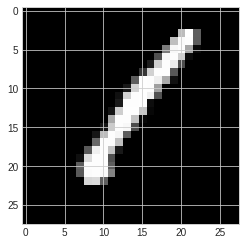

In [108]:
plt.imshow(image, cmap='gray')
plt.show()

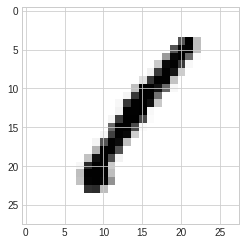

In [102]:
plt.imshow(X_train[0].reshape((28, 28)))
plt.show()

In [133]:
validation_set = val.to(device)
validation_labels = val_labels.to(device) 

params = OrderedDict(
    lr = [0.01],
    batch_size = [100],
    device = ['cuda'],
    weight_decay = [0.0])

m = RunManager()
for run in RunBuilder.get_runs(params):
    for net in models:
    
        mini_batches = [train[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
        mini_labels = [train_labels[k:k + run.batch_size] for k in range(0, train_labels.shape[0], run.batch_size)]
        optimizer = optim.Adam(net.parameters(), lr=run.lr, weight_decay=run.weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        m.begin_run(run, net)
        for epoch in range(20):
            m.begin_epoch()
            for b in range(0, len(mini_batches)):
                images = mini_batches[b].to(device)
                labels = mini_labels[b].to(device)
                preds = net(images) # pass batch
                loss = F.cross_entropy(preds, labels) # calculate loss
                optimizer.zero_grad() # zero gradients
                loss.backward() # calculate gradients
                optimizer.step() # update weights

                m.track_loss(loss)
                m.track_num_correct(preds, labels)
            m.track_val_accuracy(net)
            m.end_epoch()
            scheduler.step()
        m.end_run()

pd.DataFrame.from_dict(m.run_data).sort_values('val_accuracy', ascending=False)[0:15]

,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
0,1,1,0.146414,0.995970,0.979786,18.456687,18.456693,0.01,100,cuda,0.0
1,1,2,0.146395,0.996405,0.978929,18.445518,36.935200,0.01,100,cuda,0.0
2,1,3,0.146395,0.996357,0.979952,18.548737,55.516322,0.01,100,cuda,0.0
3,1,4,0.146383,0.996536,0.986238,18.318686,73.868199,0.01,100,cuda,0.0
4,1,5,0.146342,0.996899,0.982214,18.328296,92.229465,0.01,100,cuda,0.0
...,...,...,...,...,...,...,...,...,...,...,...
295,15,16,0.146178,0.999304,0.994524,18.351877,294.613655,0.01,100,cuda,0.0
296,15,17,0.146178,0.999304,0.994548,18.480874,313.139738,0.01,100,cuda,0.0
297,15,18,0.146178,0.999304,0.994548,18.476188,331.659298,0.01,100,cuda,0.0
298,15,19,0.146177,0.999310,0.994595,18.223090,349.933186,0.01,100,cuda,0.0


,run,epoch,loss,train_accuracy,val_accuracy,epoch duration,run duration,lr,batch_size,device,weight_decay
159,8,20,0.146165,0.999435,0.995190,18.268839,366.597533,0.01,100,cuda,0.0
158,8,19,0.146166,0.999423,0.995167,18.231417,348.285430,0.01,100,cuda,0.0
157,8,18,0.146166,0.999417,0.995167,18.308716,330.007616,0.01,100,cuda,0.0
156,8,17,0.146166,0.999411,0.995143,18.336684,311.648802,0.01,100,cuda,0.0
154,8,15,0.146169,0.999411,0.995095,18.264533,274.733908,0.01,100,cuda,0.0
155,8,16,0.146166,0.999417,0.995095,18.482972,293.260828,0.01,100,cuda,0.0
153,8,14,0.146170,0.999363,0.994929,18.356032,256.424281,0.01,100,cuda,0.0
151,8,12,0.146173,0.999357,0.994905,18.274992,219.723648,0.01,100,cuda,0.0
152,8,13,0.146171,0.999369,0.994905,18.248835,238.022597,0.01,100,cuda,0.0
258,13,19,0.146177,0.999327,0.994690,18.423761,350.047121,0.01,100,cuda,0.0


In [134]:
validation_set = val.to(device)
validation_labels = val_labels.to(device) 

preds = torch.zeros(len(val), 10).to(device)
for i in range(len(models)):
    models[i].to(device)
    with torch.no_grad():
        preds += models[i](validation_set)

preds = torch.argmax(preds, dim=1)
ensemble_correct = preds.eq(validation_labels).sum().item()
ensemble_correct/len(validation_set)
   

0.9957380952380952

In [135]:
test = test.to(device)
preds = torch.zeros(len(test), 10).to(device)
for i in range(len(models)):
    models[i].to(device)
    with torch.no_grad():
        preds += models[i](test)

preds = torch.argmax(preds, dim=1)

dataset = pd.DataFrame()
imageid = np.arange(1, 28001)
dataset['ImageId'] = imageid
preds = preds.cpu().numpy()
dataset['Label'] = preds
dataset.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [136]:
dataset.to_csv('submission_ensemble_augmented.csv', index=False)